# Exploratory Data Analysis for Text

Data can be found [here](https://www.kaggle.com/akudnaver/amazon-reviews-dataset).


In [30]:
import os

import tensorflow as tf
from tensorboard.plugins import projector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import pandas as pd
import numpy as np
import nltk
import re

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
stopwords = set(stopwords.words('english'))

In [3]:
print(tf.__version__)
print(pd.__version__)
print(nltk.__version__)

2.8.0
1.3.4
3.6.7


In [4]:
pd.set_option('max_colwidth', None)

In [9]:
df = pd.read_excel('review-details.xlsx', engine = 'openpyxl')#, usecols= ['review_title', 'review_text', 'review_rating'])

In [10]:
df.sample()

,report_date,online_store,upc,retailer_product_code,brand,category,sub_category,product_description,review_date,review_rating,...,dimension2,dimension3,dimension4,dimension5,dimension6,dimension7,dimension8,verified_purchase,helpful_review_count,review_hash_id
1441,2019-03-25,AMAZON,8710447336083,B07CCNVLXY,Persil,Homecare,Laundry,"Persil Powercaps Colour Washing Capsules 38 Wash, 1026g",2019-02-23,5,...,Colour Washing Capsules,Colour Washing Capsules,NaN,NaN,NaN,Retailer Core of the Core,Core of the Core,True,0,c38e9aef-e274-8c38-5065-7d901181f738


In [11]:
df.isnull().sum()

report_date                  0
online_store                 0
upc                          0
retailer_product_code        0
brand                        0
category                     0
sub_category                 0
product_description          0
review_date                  0
review_rating                0
review_title                98
review_text                  0
is_competitor                0
manufacturer                 0
market                       0
matched_keywords          2501
time_of_publication       2501
url                        847
review_type                  0
parent_review                0
manufacturers_response    2501
dimension1                   0
dimension2                   0
dimension3                 191
dimension4                2501
dimension5                2501
dimension6                2501
dimension7                   2
dimension8                   0
verified_purchase            0
helpful_review_count         0
review_hash_id               0
dtype: i

<AxesSubplot:xlabel='category', ylabel='count'>

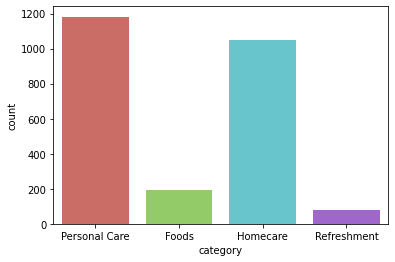

In [13]:
sns.countplot(x='category', data=df, palette='hls')

<AxesSubplot:xlabel='review_rating_label', ylabel='count'>

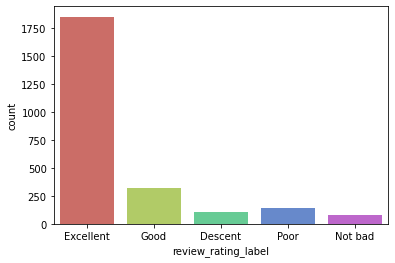

In [20]:
sns.countplot(x='review_rating_label', data = df, palette = 'hls')

<AxesSubplot:xlabel='review_rating_label', ylabel='count'>

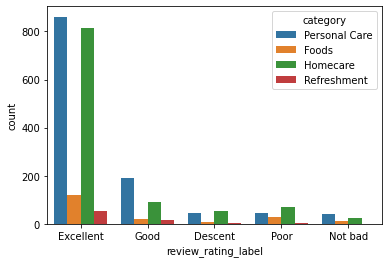

In [14]:
mapping = {1: 'Poor', 2: 'Not bad', 3: 'Descent', 4: 'Good', 5: 'Excellent'}

df['review_rating_label'] = df['review_rating'].map(mapping)

sns.countplot(x='review_rating_label', hue='category', data= df)

In [21]:
LE = LabelEncoder()
df['relevance_enc'] = LE.fit_transform(df['review_rating'])
X = df.review_text #the column text contains textual data to extract features from
y = df.relevance_enc #this is the column we are learning to predict.

In [22]:
# Code to produce a dictionary to retrieve correct tags
text_tags = df['relevance_enc'].unique()
text_tags = list(np.sort(text_tags))

In [23]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y,
    train_size=0.9,
    test_size=0.1,
    # random but same for all run
    random_state=2022,
    # keep same proportion of 'target' in test and target data
    stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr,
    train_size=0.8,
    test_size=0.2,
    # random but same for all run
    random_state=2022,
    # keep same proportion of 'target' in test and target data
    stratify=y_tr
)

In [24]:
train_texts = X_train
train_labels = y_train
test_texts = X_test
test_labels = y_test
val_texts = X_val
val_labels = y_val

In [27]:
vect = CountVectorizer(max_features=1000) #instantiate a vectorizer

X_train_dtm = vect.fit_transform(X_train)

In [28]:
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)

(1800, 1000) (251, 1000)


In [31]:
# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

(1800, 3000) (251, 3000)
Accuracy:  0.7450199203187251


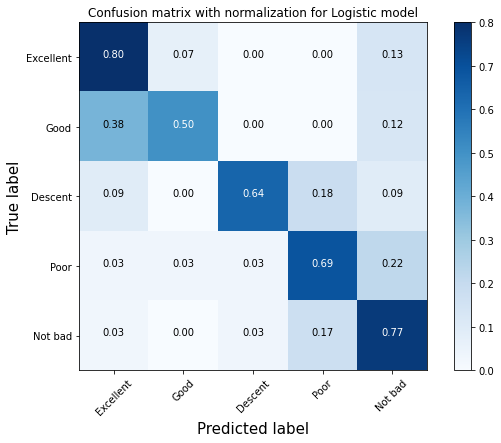

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix , classification_report

vect = CountVectorizer(max_features=3000) #
X_train_bow = vect.fit_transform(X_train)#
X_test_bow = vect.transform(X_test)

tfidf = TfidfTransformer()
X_train_dtm = tfidf.fit_transform(X_train_bow)#
X_test_dtm = tfidf.transform(X_test_bow)
print(X_train_dtm.shape, X_test_dtm.shape)
#i.e., the dimension of our feature vector is 7394!

logreg = LogisticRegression(class_weight="balanced", 
                            solver = 'lbfgs',
                            multi_class = 'multinomial',
                            max_iter= 1500,
                            random_state=2022) #instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=list(df['review_rating_label'].unique()),normalize=True,
                      title='Confusion matrix with normalization for Logistic model')